In [1]:
# PROJECT/IMPLEMENTATION IDEAS
# 1. Historical market cap, % bitcoin (requires crawling https://coinmarketcap.com/historical/)
# 2. Twitter sentiment analysis of Bitcoin vs price
# 3. Bitcoin vs. altcoin market caps
# 4. Transaction fees, user/address count(?), other features(?) vs bitcoin price
# 5. Usage by country
# 6. Bitcoin trading by exchange
# 7. Bitcoin trading by currency
# 8. Increase in leverage?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import dateutil.parser
from pprint import pprint
import json
import time
import sys

# APIs
import quandl
import coinmarketcap

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Quandl API Calls
df_price = pd.read_csv('https://www.quandl.com/api/v3/datasets/BNC3/GWA_BTC.csv?api_key=pvPBMBW8afR_HqVfio9o') # Price, volume
df_fees = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/TRFUS.csv?api_key=pvPBMBW8afR_HqVfio9o') # Txn fees
df_cost = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=pvPBMBW8afR_HqVfio9o') # cost per txn
df_no = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NTRAN.csv?api_key=pvPBMBW8afR_HqVfio9o') # num txns
df_noblk = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NTRBL.csv?api_key=pvPBMBW8afR_HqVfio9o') # txns per block
df_blksz = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/AVBLS.csv?api_key=pvPBMBW8afR_HqVfio9o') # blk size
df_unq = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=pvPBMBW8afR_HqVfio9o') # unique addys
df_hash = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/HRATE.csv?api_key=pvPBMBW8afR_HqVfio9o') # hash rate
df_diff = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/DIFF.csv?api_key=pvPBMBW8afR_HqVfio9o') # difficulty

In [4]:
sys.executable

'/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/bin/python'

In [5]:
# Helper functions
def to_currency(int):
    return "${:,.0f}".format(int//1000000)

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [6]:
df = df_price.drop('Open', 1)
df = df.drop('High', 1)
df = df.drop('Low', 1)
df = df.rename(columns={'Close': 'Price'})
df = df_fees.merge(df, how='inner', on='Date')
df = df.rename(columns={'Value': 'TxFees'})
df = df_cost.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'CostperTxn'})
df = df_no.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'NoTxns'})
df = df_noblk.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'NoperBlock'})
df = df_blksz.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'AvgBlkSz'})
df = df_unq.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'UniqueAddresses'})
df = df_hash.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'HashRate'})
df = df_diff.merge(df,how='inner',on='Date')
df = df.rename(columns={'Value': 'Difficulty'})

df['Date'] = df['Date'].apply(to_date)
df = df[['Date', 'Price','Volume', 'VWAP', 'TWAP', 'TxFees','CostperTxn','NoTxns','NoperBlock','AvgBlkSz','UniqueAddresses','HashRate','Difficulty']]
df_hist = df # fully loaded


df_hist.head(2)

,Date,Price,Volume,VWAP,TWAP,TxFees,CostperTxn,NoTxns,NoperBlock,AvgBlkSz,UniqueAddresses,HashRate,Difficulty
0,2018-01-24,11459.922995,399131.381733,11164.463656,11179.762673,3.209325e+06,103.113799,271936.0,1536.361582,1.070345,547568.0,1.960220e+07,2.227848e+12
1,2018-01-23,10962.717701,523048.455425,10921.000571,10929.333538,3.317461e+06,103.148288,245562.0,1470.431138,1.081038,574420.0,1.849473e+07,2.227848e+12


In [7]:
df_hist.tail(2)

,Date,Price,Volume,VWAP,TWAP,TxFees,CostperTxn,NoTxns,NoperBlock,AvgBlkSz,UniqueAddresses,HashRate,Difficulty
1393,2014-04-02,437.078735,114052.961126,460.19242,465.932466,5825.303232,30.917221,66756.0,426.0,0.199055,152718.0,46045.092129,5.006861e+09
1394,2014-04-01,479.562538,74776.478845,482.75744,482.815530,6017.202629,33.258538,64692.0,334.0,0.199917,157020.0,44551.737790,5.006861e+09


In [8]:
df = df_hist[['Date', 'Price','Volume', 'TxFees','NoTxns','AvgBlkSz','UniqueAddresses','HashRate']]


In [9]:
df.corr().sort_values('Price')

,Price,Volume,TxFees,NoTxns,AvgBlkSz,UniqueAddresses,HashRate
Volume,-0.069889,1.000000,-0.059329,0.253365,0.224742,0.167496,-0.035869
AvgBlkSz,0.498712,0.224742,0.376756,0.947420,1.000000,0.911446,0.670100
NoTxns,0.538945,0.253365,0.421688,1.000000,0.947420,0.960502,0.688463
UniqueAddresses,0.708969,0.167496,0.582744,0.960502,0.911446,1.000000,0.820529
TxFees,0.889819,-0.059329,1.000000,0.421688,0.376756,0.582744,0.749951
HashRate,0.914902,-0.035869,0.749951,0.688463,0.670100,0.820529,1.000000
Price,1.000000,-0.069889,0.889819,0.538945,0.498712,0.708969,0.914902


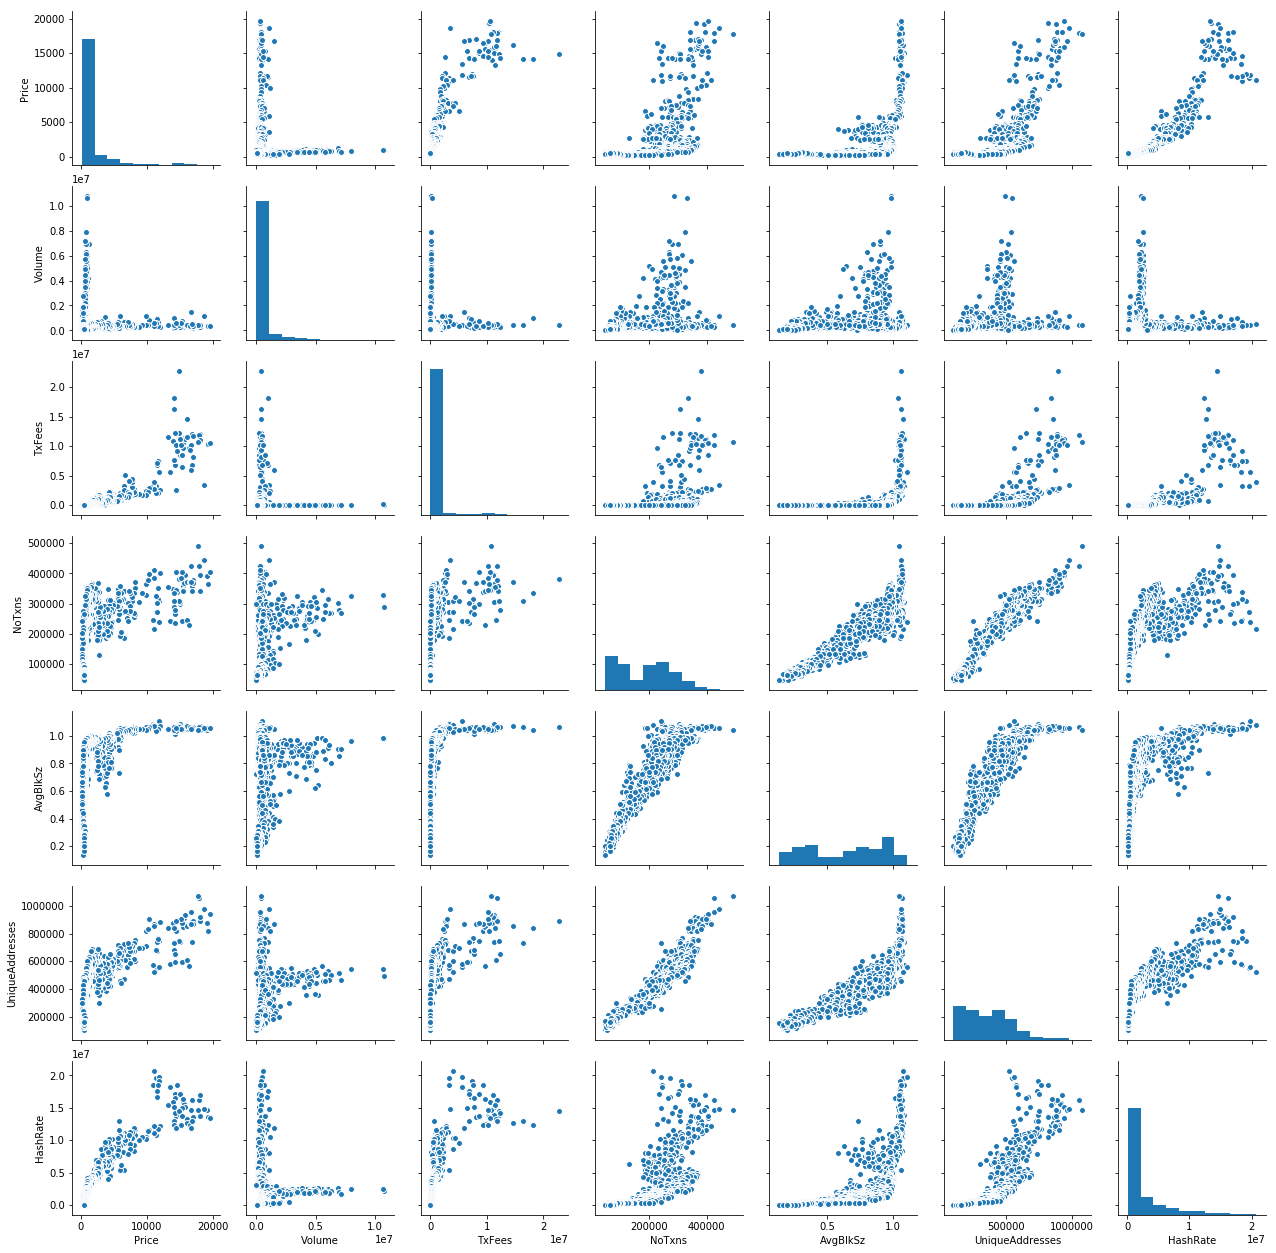

In [10]:
sns.pairplot(df);

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 8 columns):
Date               1395 non-null datetime64[ns]
Price              1395 non-null float64
Volume             1395 non-null float64
TxFees             1395 non-null float64
NoTxns             1395 non-null float64
AvgBlkSz           1395 non-null float64
UniqueAddresses    1395 non-null float64
HashRate           1395 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 138.1 KB


In [12]:
# STATSMODELS
# Create your feature matrix (X) and target vector (y)
df_stats = df[['Price','Volume','HashRate']]
y, X = patsy.dmatrices('Price ~ Volume + HashRate', data=df_stats, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     3611.
Date:                Thu, 25 Jan 2018   Prob (F-statistic):               0.00
Time:                        15:47:02   Log-Likelihood:                -11928.
No. Observations:                1395   AIC:                         2.386e+04
Df Residuals:                    1392   BIC:                         2.388e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -286.7602     47.253     -6.069      0.000    -379.455    -194.065
Volume        -0.0001    3.5e-05     -3.443      0.001      -0.000   -5.19e-05
HashRate       0.0008   9.43e-06     84.740      0.000       0.001       0.001
==============================================================================
Omnibus:                      728.978   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10848.995
Skew:                           2.074   Prob(JB):                         0.00
Kurtosis:                      16.017   Cond. No.                     6.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# SKLEARN
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:,2:]
# Choose the response variable(s)
y = df.iloc[:,1]
# Fit the model to the full dataset
lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))

0.9415147569378172


In [14]:
df.columns

Index(['Date', 'Price', 'Volume', 'TxFees', 'NoTxns', 'AvgBlkSz',
       'UniqueAddresses', 'HashRate'],
      dtype='object')

In [15]:
# Create an empty model
lr1 = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['Volume','TxFees','HashRate']]
# Choose the response variable(s)
y = df['Price']
# Fit the model to the full dataset
lr1.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr1.score(X,y))
print(lr1.intercept_)
print(lr1.coef_)

0.9323448482121339
27.063603692356082
[-7.16545396e-05  7.43296757e-04  4.95036314e-04]


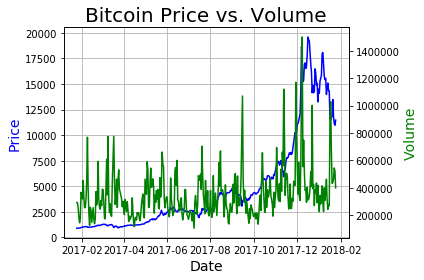

None


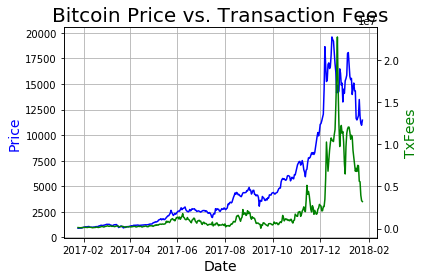

None


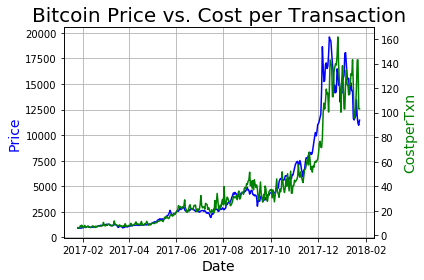

None


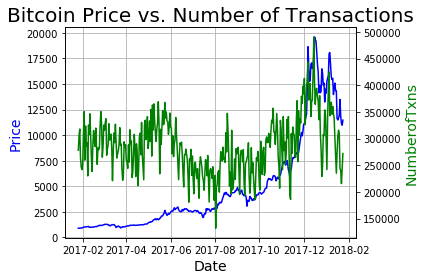

None


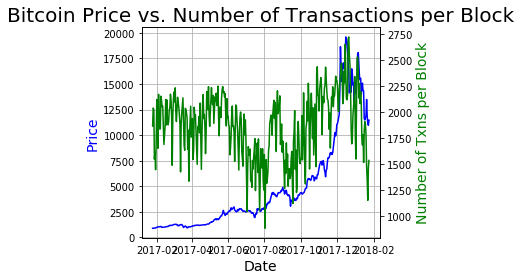

None


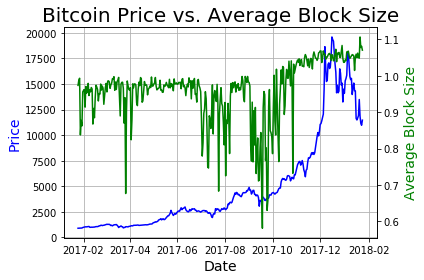

None


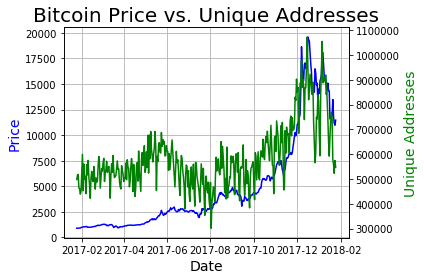

None


In [16]:
# BTC Price vs Volume
df = df_hist[:365]

y1 = pd.Series(df['Price'])
y2 = pd.Series(df['Volume'])
x = pd.Series(df['Date'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Volume",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Volume", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig1.png')
print(plt.show())

# BTC Price vs Transaction Fees
y2 = pd.Series(df['TxFees'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("TxFees",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Transaction Fees", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig2.png')
print(plt.show())

# BTC Price vs Cost per Transaction
y2 = pd.Series(df['CostperTxn'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("CostperTxn",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Cost per Transaction", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig3.png')
print(plt.show())

# BTC Price vs Number of Transactions
y2 = pd.Series(df['NoTxns'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("NumberofTxns",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Number of Transactions", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig4.png')
print(plt.show())

# BTC Price vs Number of Transactions per Block
y2 = pd.Series(df['NoperBlock'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Number of Txns per Block",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Number of Transactions per Block", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig5.png')
print(plt.show())

# BTC Price vs Block Size
y2 = pd.Series(df['AvgBlkSz'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Average Block Size",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Average Block Size", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig6.png')
print(plt.show())

# BTC Price vs Unique Addresses
y2 = pd.Series(df['UniqueAddresses'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Price",fontsize=14,color='blue')
ax2.set_ylabel("Unique Addresses",fontsize=14,color='green')
ax.grid(True)
plt.title("Bitcoin Price vs. Unique Addresses", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
plt.tight_layout()
plt.savefig('charts/fig7.png')
print(plt.show())

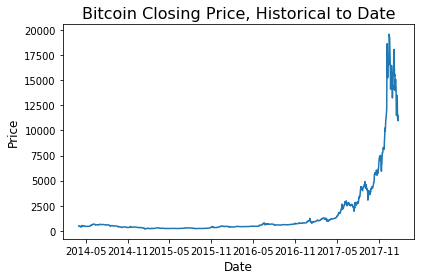

None


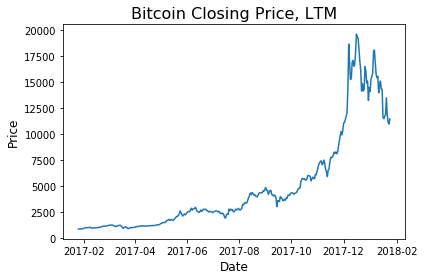

None


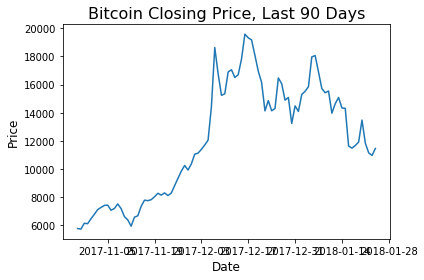

None


In [17]:
# Bitcoin prices, called via Quandl API
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BNC3/GWA_BTC.csv?api_key=pvPBMBW8afR_HqVfio9o')
# mydata['Date']=mydata['Date'].apply(to_date)
df = df_hist
y = pd.Series(df['Price'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Closing Price, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCPriceQuandl.png')
print(plt.show())

df = df[:365]
y = pd.Series(df['Price'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Closing Price, LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/LTMBTCPriceQuandl.png')
print(plt.show())

df = df[:90]
y = pd.Series(df['Price'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Closing Price, Last 90 Days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/90DBTCPriceQuandl.png')
print(plt.show())

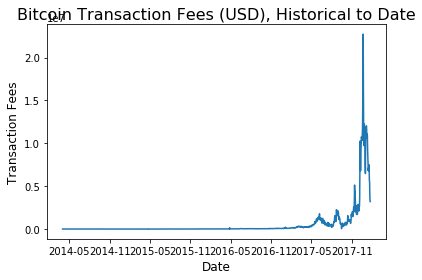

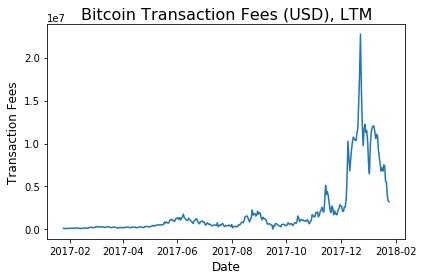

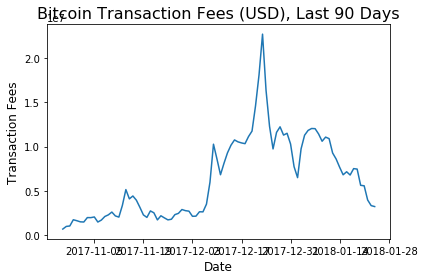

In [18]:
# Quandl: BTC transaction fees USD
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/TRFUS.csv?api_key=pvPBMBW8afR_HqVfio9o')
# mydata['Date']=mydata['Date'].apply(to_date)
df = df_hist
y = pd.Series(df['TxFees'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnFeesQuandl.png')
plt.show()

df = df[:365]
y = pd.Series(df['TxFees'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/LTMBTCTxnFeesQuandl.png')
plt.show()

df = df[:90]
y = pd.Series(df['TxFees'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Transaction Fees (USD), Last 90 Days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transaction Fees', fontsize=12)
plt.tight_layout()
plt.savefig('charts/90DBTCTxnFeesQuandl.png')
plt.show()

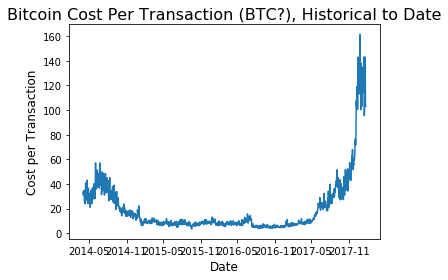

In [19]:
# Quandl: BTC Cost Per Transaction BTC(?)
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=pvPBMBW8afR_HqVfio9o')
# mydata['Date']=mydata['Date'].apply(to_date)
df = df_hist
y = pd.Series(df['CostperTxn'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Cost Per Transaction (BTC?), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cost per Transaction', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCCostperTxnQuandl.png')
plt.show()

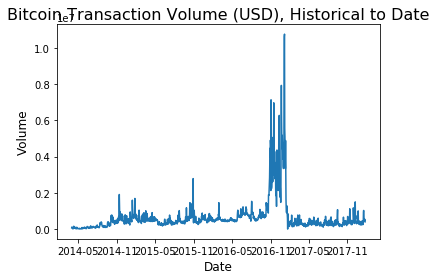

In [20]:
# Quandl: BTC transaction volume USD
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/ETRVU.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_hist
y = pd.Series(df['Volume'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Transaction Volume (USD), Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnVolQuandl.png')
plt.show()

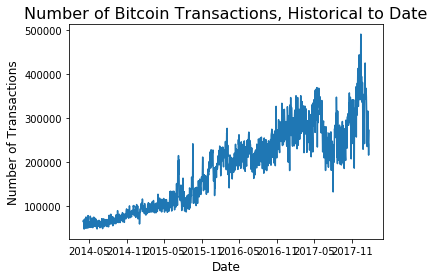

In [21]:
# Quandl: # BTC Transactions
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NTRAN.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_hist
y = pd.Series(df['NoTxns'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Number of Bitcoin Transactions, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnAmtQuandl.png')
plt.show()

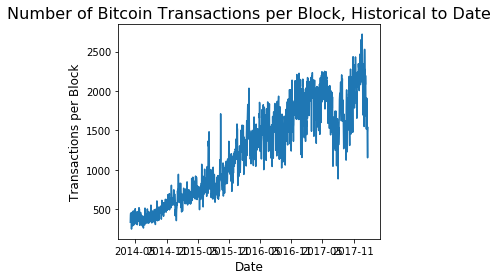

In [22]:
# Quandl: # BTC Transactions per Block
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NTRBL.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_hist
y = pd.Series(df['NoperBlock'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Number of Bitcoin Transactions per Block, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Transactions per Block', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCTxnperBlockQuandl.png')
plt.show()

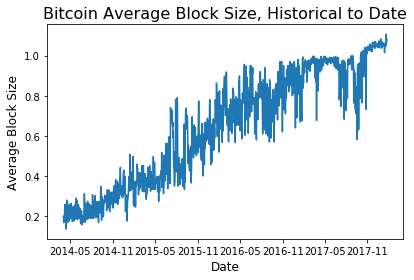

In [23]:
# Quandl: BTC Average Block Size
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/AVBLS.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_hist
y = pd.Series(df['AvgBlkSz'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Average Block Size, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Block Size', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCAvgBlockSizeQuandl.png')
plt.show()

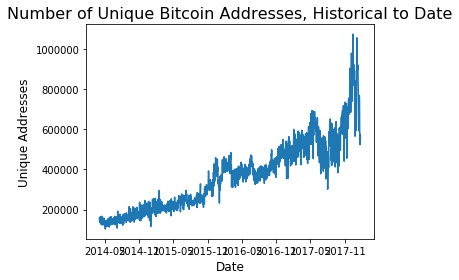

In [24]:
# Quandl: Unique BTC Addresses
# mydata = pd.read_csv('https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=pvPBMBW8afR_HqVfio9o')
df = df_hist
y = pd.Series(df['UniqueAddresses'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Number of Unique Bitcoin Addresses, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Unique Addresses', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCNoAddressesQuandl.png')
plt.show()

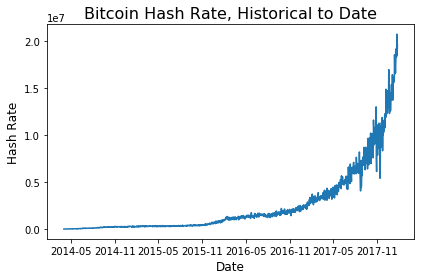

In [25]:
# Quandl: BTC Hash Rate
df = df_hist
y = pd.Series(df['HashRate'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Hash Rate, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hash Rate', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCHashRateQuandl.png')
plt.show()

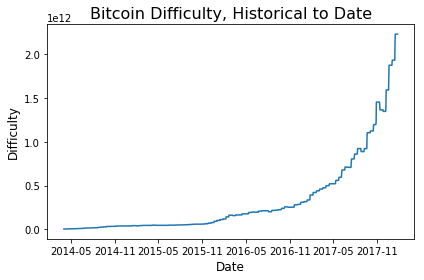

In [26]:
# Quandl: BTC Difficulty
df = df_hist
y = pd.Series(df['Difficulty'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Difficulty, Historical to Date",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Difficulty', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistBTCDifficultyQuandl.png')
plt.show()

In [27]:
# Coinmarketcap: Current
url = 'https://coinmarketcap.com/all/views/all/'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page,"lxml")

tables=soup.find_all("table")

rows=[row for row in tables[0].find_all('tr')]
df = pd.read_html(tables[0].prettify())[0]
df.head()

,#,Name,Symbol,Market Cap,Price,Circulating Supply,Volume (24h),% 1h,% 24h,% 7d
0,1,BTC Bitcoin,BTC,"$188,960,326,010",$11230.00,16826387,"$8,906,810,000",-0.82%,-0.82%,-3.02%
1,2,ETH Ethereum,ETH,"$102,367,075,961",$1053.05,97210081,"$4,059,220,000",-1.30%,0.11%,0.60%
2,3,XRP Ripple,XRP,"$50,763,772,740",$1.31,"38,739,142,811 *","$1,009,490,000",-1.08%,-2.87%,-18.96%
3,4,BCH Bitcoin Cash,BCH,"$27,752,554,256",$1639.08,16931788,"$520,134,000",-1.13%,-0.32%,-9.31%
4,5,ADA Cardano,ADA,"$16,451,063,308",$0.634513,"25,927,070,538 *","$659,275,000",-1.10%,1.69%,-4.33%


In [28]:
# Coinmarketcap: weekly beginning in 2013; would ideally like to crawl this to compile all weekly snapshots
# into a single table
url = 'https://coinmarketcap.com/historical/20130428/'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page,"lxml")

tables=soup.find_all("table")

rows=[row for row in tables[0].find_all('tr')]
df = pd.read_html(tables[0].prettify())[0]
df
# mkt_cap = {}
# for row in df['Market Cap']:
#     mkt_caps['url_b'] = 
#     no = int(row.replace('$','').replace(',',''))
#     sm += no
# print(sm)
    
# print(df['Market Cap'])
# for row in rows:
#     print(row)
#     df['Market Cap'] = df['Market Cap'].replace('$','').replace(',','')
# df['Market Cap']
# sum = df.sum('Market Cap')
# print(sum)
# df = df[['Market Cap']].replace('$','').replace(',','')

,#,Name,Symbol,Market Cap,Price,Circulating Supply,Volume (24h),% 1h,% 24h,% 7d
0,1,BTC Bitcoin,BTC,"$1,503,882,095",$135.58,11092162,Low Vol,0.32%,?,?
1,2,LTC Litecoin,LTC,"$74,426,612",$4.33,17170739,Low Vol,0.12%,?,?
2,3,PPC Peercoin,PPC,"$7,311,640",$0.389696,18762419,Low Vol,0.08%,?,?
3,4,NMC Namecoin,NMC,"$6,414,722",$1.18,5417308,Low Vol,1.37%,?,?
4,5,TRC Terracoin,TRC,"$1,522,275",$0.654561,2325642,Low Vol,0.53%,?,?
5,6,DVC Devcoin,DVC,"$1,460,589",$0.000334,4367702656,Low Vol,0.56%,?,?
6,7,NVC Novacoin,NVC,"$1,152,424",$4.21,273797,Low Vol,0.33%,?,?


In [29]:
import re
import datetime
import json
    

In [30]:
mkt_cap = {}
date_list = []
start_date = 20130428
end_date = datetime.datetime.now()
iterations = str((end_date-to_date(str(start_date)))//7)
iterations = re.split(' ',iterations)
iterations = iterations[0]
end_date = str(end_date).replace('-','').replace(':','')
end_date = re.split(' ',end_date)
end_date = int(end_date[0])

for i in range(int(iterations)+1):
    date = to_date(str(start_date)) + datetime.timedelta(7*i)
    date = str(date).replace('-','')
    date = re.split(' ',date)
    date = date[0]
    date_list.append(date)

In [31]:
# run coinmarketcap_hist.py weekly to generate .json file
# !python coinmarketcap_hist.py
mkt_cap = pd.read_json('coinmarketcap_hist.json').T
mkt_cap = mkt_cap[['BTC','LTC','ETH','EOS','ADA']]
mkt_cap.tail()

,BTC,LTC,ETH,EOS,ADA
20171224,"$235,595,837,210","$15,053,302,927","$66,472,347,199","$4,538,189,807","$10,115,398,471"
20171231,"$220,903,949,498","$12,000,947,760","$69,767,510,695","$4,951,228,781","$18,030,140,406"
20180107,"$287,582,315,011","$16,400,509,416","$106,276,577,298","$7,511,110,027","$26,227,470,004"
20180114,"$236,679,147,035","$13,826,119,273","$132,809,805,708","$9,155,082,270","$21,223,108,072"
20180121,"$207,286,525,403","$10,979,322,163","$107,468,021,289","$8,638,739,352","$17,067,241,486"


In [61]:
base = '/Volumes/BC Clutch/Dropbox/Programming/BootCamps/Metis/00Bootcamp/McMahon_Metis/Project_2/'
hourly = pd.read_json(base + 'coinmarketcap_hourly.json',convert_axes=False).T
hourly = hourly[['BTC','LTC','ETH','EOS','ADA']]
hourly['Date'] = hourly.index
hourly['Date'] = pd.to_datetime(hourly['Date'])
hourly.tail()

,BTC,LTC,ETH,EOS,ADA,Date
201801251630,"$189,845,676,031","$9,908,892,854","$102,694,303,294","$9,034,271,892","$16,531,152,029",2018-01-25 16:30:00
201801251636,"$190,994,919,971","$9,905,707,510","$103,456,434,794","$9,036,656,119","$16,512,743,809",2018-01-25 16:36:00
201801251641,"$190,747,571,714","$9,908,343,657","$102,495,993,567","$9,032,075,895","$16,505,328,667",2018-01-25 16:41:00
201801251646,"$190,747,719,085","$9,914,791,832","$102,395,214,735","$9,040,000,127","$16,513,495,694",2018-01-25 16:46:00
201801251651,"$191,669,807,175","$9,943,569,838","$103,771,721,852","$9,100,358,817","$16,539,137,567",2018-01-25 16:51:00


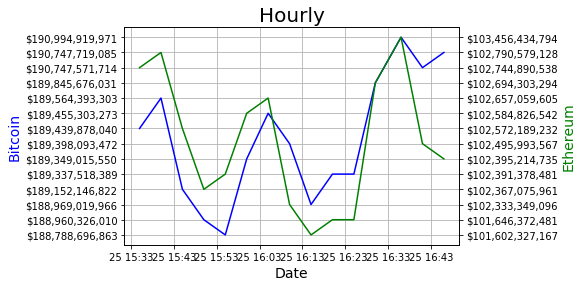

None


In [60]:
y1 = pd.Series(hourly['BTC'])
y2 = pd.Series(hourly['ETH'])
x = pd.Series(hourly['Date'])

ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(x,y1, 'b',linewidth=1.5)
ax2.plot(x,y2, 'g',linewidth=1.5)
ax.set_ylabel("Bitcoin",fontsize=14,color='blue')
ax2.set_ylabel("Ethereum",fontsize=14,color='green')
ax.grid(True)
plt.title("Hourly", fontsize=20,color='black')
ax.set_xlabel('Date', fontsize=14, color='black')
# plt.tight_layout()
plt.savefig('charts/hourly.png')
print(plt.show())

        Date     Open     High      Low    Close       Volume    Market Cap
0 2018-01-23  10944.5  11377.6  10129.7  10868.4   9660610000  184087000000
1 2018-01-22  11633.1  11966.4  10240.2  10931.4  10537400000  195645000000
2 2018-01-21  12889.2  12895.9  11288.2  11600.1   9935180000  216740000000
3 2018-01-20  11656.2  13103.0  11656.2  12899.2  11801700000  195979000000
4 2018-01-19  11429.8  11992.8  11172.1  11607.4  10740400000  192150000000


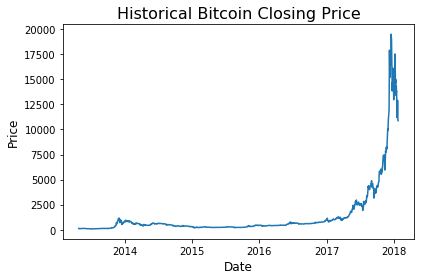

None


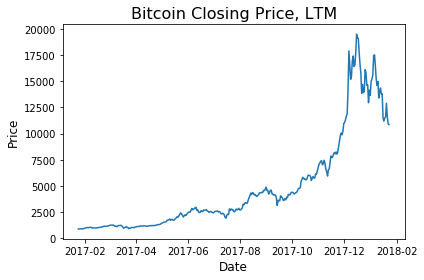

None


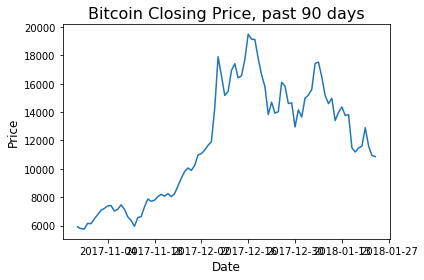

In [33]:
# Coinmarketcap scraping: Bitcoin by time period
url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20180123'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page,"lxml")
tables=soup.find_all("table")

rows=[row for row in tables[0].find_all('tr')]
df = pd.read_html(tables[0].prettify())[0]
df['Date']=df['Date'].apply(to_date)
print(df.head())

y = pd.Series(df['Close'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Historical Bitcoin Closing Price",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistoricalBitcoinPrice.png')
print(plt.show())

# Bitcoin Closing Price, past year
df = df[:365]
y = pd.Series(df['Close'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Closing Price, LTM",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/BitcoinPrice2017.png')
print(plt.show())

# Bitcoin past 90 days
df = df[:90]
y = pd.Series(df['Close'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Bitcoin Closing Price, past 90 days",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/BitcoinPrice2017.png')
plt.show()

        Date     Open     High      Low    Close      Volume    Market Cap
0 2018-01-23  1004.17  1023.23   920.54   986.23  3556700000   97554300000
1 2018-01-22  1055.35  1089.10   930.74  1003.26  3810100000  102504000000
2 2018-01-21  1155.68  1155.68  1021.50  1049.58  3378090000  112226000000
3 2018-01-20  1044.95  1167.11  1044.95  1155.15  3975190000  101451000000
4 2018-01-19  1028.82  1093.22  1003.71  1039.10  4084450000   99863900000


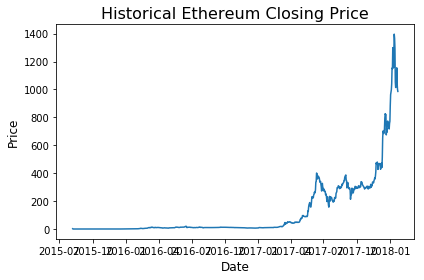

None
          Date   Open   High    Low  Close   Volume Market Cap
360 2017-01-28  10.54  10.58  10.43  10.56  6580700  930688000
361 2017-01-27  10.58  10.61  10.44  10.54  7189170  934404000
362 2017-01-26  10.57  10.67  10.51  10.59  8465020  932575000
363 2017-01-25  10.62  10.62  10.48  10.57  6751450  936769000
364 2017-01-24  10.73  10.77  10.57  10.63  8327330  946083000


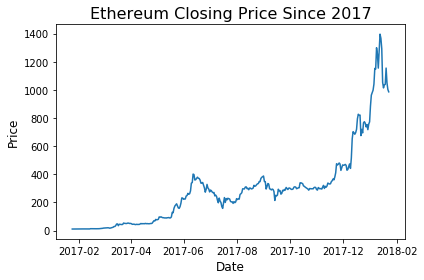

None
          Date   Open   High    Low  Close   Volume Market Cap
360 2017-01-28  10.54  10.58  10.43  10.56  6580700  930688000
361 2017-01-27  10.58  10.61  10.44  10.54  7189170  934404000
362 2017-01-26  10.57  10.67  10.51  10.59  8465020  932575000
363 2017-01-25  10.62  10.62  10.48  10.57  6751450  936769000
364 2017-01-24  10.73  10.77  10.57  10.63  8327330  946083000


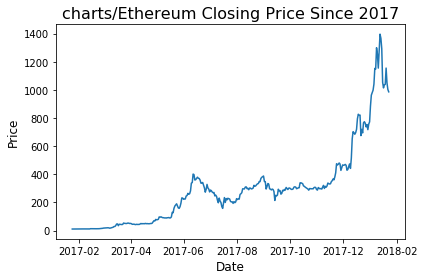

In [34]:
# Coinmarketcap scraping: Ethereum
url = 'https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end=20180123'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page,"lxml")
tables=soup.find_all("table")

rows=[row for row in tables[0].find_all('tr')]
df = pd.read_html(tables[0].prettify())[0]
df['Date']=df['Date'].apply(to_date)
print(df.head())

y = pd.Series(df['Close'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Historical Ethereum Closing Price",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/HistoricalEthereumPrice.png')
print(plt.show())

# LTM
df = df[:365]
print(df.tail())
y = pd.Series(df['Close'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("Ethereum Closing Price Since 2017",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('charts/EthereumPrice2017.png')
print(plt.show())

# Last 90 days
df = df[:365]
print(df.tail())
y = pd.Series(df['Close'])
x = pd.Series(df['Date'])

plt.plot(x,y)
plt.title("charts/Ethereum Closing Price Since 2017",fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.savefig('EthereumPrice2017.png')
plt.show()

In [35]:
# Bitcoin futures scraping
url = 'http://www.cmegroup.com/trading/equity-index/us-index/bitcoin.html'
response=requests.get(url)
page=response.text
soup=BeautifulSoup(page,"lxml")

tables=soup.find_all("table")

rows=[row for row in tables[0].find_all('tr')]
df = pd.read_html(tables[0].prettify())[0]
df = df[:5]
df

,Month,Charts,Last,Change,Prior Settle,Open,High,Low,Volume,Hi / Low Limit,Updated
0,JAN 2018,Show Price Chart,-,-,11245.0,-,-,-,0.0,11890 / 10340,17:35:46 CT 25 Jan 2018
1,FEB 2018,Show Price Chart,11105,-95,11200.0,11060,11150,11060,7.0,12070 / 10500,17:40:34 CT 25 Jan 2018
2,MAR 2018,Show Price Chart,11230,-20,11250.0,11230,11230,11230,2.0,12110 / 10540,17:36:10 CT 25 Jan 2018
3,APR 2018,Show Price Chart,-,-,11305.0,-,-,-,0.0,12165 / 10595,16:45:00 CT 25 Jan 2018
4,JUN 2018,Show Price Chart,-,-,11385.0,-,-,-,0.0,12245 / 10675,16:45:00 CT 25 Jan 2018


In [36]:
# Twitter sentiment anlysis
# import tweepy
# from tweepy import OAuthHandler

# consumer_key = 'vZ2rePzW00X6Mr2NVbxcRUSMm'
# consumer_secret = 'XkT96BYG7RBJKBdKP2uBl2z4WzPVjTbH155bUldCDT1xVdGiVM'
# access_token = '66541059-BLlhwk0IE57qhXQux6XjCKOeVy5MC8NxWR6yaoKQa'
# access_secret = 'RWiaKbiPXVZwRslwr9KEWd6ELn4MvEn6eCRSo8npkkZ8t'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth)

In [37]:
# def process_or_store(tweet):
#     print(json.dumps(tweet))

In [38]:
tweets = pd.read_json('bitcoin.json')
tweets

ValueError: Trailing data

In [ ]:
# import pandas
# import json

# from tweepy import Stream
# from tweepy.streaming import StreamListener

# class MyListener(StreamListener):

#     def on_data(self, data):
#         try:
#             with open('python.json', 'a') as f:
#                 f.write(data)
#                 return True
#         except BaseException as e:
#             print("Error on_data: %s" % str(e))
#         return True

#     def on_error(self, status):
#         print(status)
#         return True

# twitter_stream = Stream(auth, MyListener())
# twitter_stream.filter(track=['#python'])




In [ ]:
# dates_ITAvWAL = []
# # f is the file pointer to the JSON data set
# for line in f:
#     tweet = json.loads(line)
#     # let's focus on hashtags only at the moment
#     terms_hash = [term for term in preprocess(tweet['text']) if term.startswith('#')]
#     # track when the hashtag is mentioned
#     if '#itavwal' in terms_hash:
#         dates_ITAvWAL.append(tweet['created_at'])
 
# # a list of "1" to count the hashtags
# ones = [1]*len(dates_ITAvWAL)
# # the index of the series
# idx = pandas.DatetimeIndex(dates_ITAvWAL)
# # the actual series (at series of 1s for the moment)
# ITAvWAL = pandas.Series(ones, index=idx)
 
# # Resampling / bucketing
# per_minute = ITAvWAL.resample('1Min', how='sum').fillna(0)

In [ ]:
# import pandas
# import json

# from tweepy import Stream
# from tweepy.streaming import StreamListener

# class MyListener(StreamListener):

#     def on_data(self, data):
#         try:
#             with open('bitcoin.json', 'a') as f:
#                 f.write(data)
#                 return True
#         except BaseException as e:
#             print("Error on_data: %s" % str(e))
#         return True

#     def on_error(self, status):
#         print(status)
#         return True

# twitter_stream = Stream(auth, MyListener())
# twitter_stream.filter(track=['#bitcoin'])

In [ ]:
# import json

# with open('python.json', 'r') as f:
#     line = f.readline() # read only the first tweet/line
#     tweet = json.loads(line) # load it as Python dict
#     print(json.dumps(tweet, indent=4)) # pretty-print

In [ ]:
# public_tweets = api.search('Bitcoin')

# for tweet in public_tweets:
#     print(tweet.text)
#     analysis = TextBlob(tweet.text)
#     print(analysis.sentiment)

In [ ]:
# Resources
# https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
# http://cs229.stanford.edu/proj2015/029_report.pdf
# http://text-processing.com/ API